# Behavior Cloning

## Objective: Fly balloon as far as possible.

1.Imitation learning is a paradigm where an agent learns to mimic an **expert's behavior** instead of learning purely from trial-and-error rewards (e.g., reinforcement learning).

- The simplest common approach is called "**behavior cloning**" (BC). It treats the expert's demonstrations as training data samples; train a policy using the expert's input(state) and output(action) pairs via supervised learning.

## For Colab users

In [ ]:
## Colab users ##

# Clone the repository
!git clone https://github.com/sdean-group/balloon-outreach.git
%cd balloon-outreach
!git checkout main

In [ ]:
## Colab users ##

# Install required packages
!pip install -r requirements.txt

In [ ]:
## Colab users ##

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
## Colab users ##

import sys
sys.path.append('/content/balloon-outreach/')

datapath = "/content/drive/MyDrive/era5_data.nc"

## For locals:

In [1]:
datapath = 'era5_data.nc'

## Import Packages

In [2]:
import xarray as xr
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import time

from env.balloon_env import BalloonERAEnvironment
from agent.mppi_agent import MPPIAgentWithCostFunction, MPPIAgent
from utils.learning_util import plot_expert_summary, plot_agent_summary

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

## Setup Environment

In [29]:
ds          = xr.open_dataset(datapath, engine="netcdf4")
start_time  = dt.datetime(year=2024, month=7, day=1, hour=0, minute=0)


#This is Ithaca
initial_lat = 42.6
initial_lon = -76.5
initial_alt = 10.0

target_lat = None
target_lon = None
target_alt = None

time_step = 120 #120 seconds
objective = 'fly'

env = BalloonERAEnvironment(ds=ds,
                            start_time=start_time,
                            initial_lat=initial_lat,
                            initial_lon=initial_lon,
                            initial_alt=initial_alt,
                            target_lat=target_lat,
                            target_lon=target_lon,
                            target_alt=target_alt,
                            objective=objective,
                            dt=time_step,
                            viz=False)


WindField initialized with noise enabled: True


In [30]:
env.wind_field.disable_noise()
initial_state = env.reset()
print(initial_state) # 21-dimensional vector

# state = (latitude, longitude, altitude, volume/max_volume, sand/max_sand,
# vertical velocity, current_time, uv vectors in 7 different pressure levels)

[ 42.6        -76.5         10.           1.           1.
   0.           0.           2.68826294  -2.50693054  11.1584198
  -7.97099304  14.01635132  -5.00876465  27.14085999   3.41699524
  34.82033386  14.09255371  38.58664856   7.6340332   18.78843994
  -4.25058899]


## Define expert policy

In [31]:
# Parameters for MPPI agent

max_steps = int(1440/(time_step/60)) #1 day

num_samples=10
acc_bounds= (-0.1, 0.1)
noise_std = 0.1
num_iterations=1
temperature=10
horizon = 5

In [32]:
expert = MPPIAgentWithCostFunction(target_lat=target_lat,
                                   target_lon=target_lon,
                                   target_alt=target_alt,
                                   num_samples=num_samples,
                                   acc_bounds= acc_bounds,
                                   noise_std=noise_std,
                                   num_iterations=num_iterations,
                                   temperature=temperature,
                                   horizon=horizon,
                                   visualize=False,
                                   objective=objective)

## Collect expert state-action pair

In [33]:
# Run an episode from an expert and collect its behavior

def run_expert_episode(
        env: BalloonERAEnvironment,
        agent:MPPIAgent,
        max_steps: int = 100,
        dt: int = 60,
        policy_name: str='expert'):
    """
    Run one episode with the given agent,
    collect state-action pair of the agent,
    and plot its trajectory in the given environment.
    """
    # Save state-action pairs from expert policy
    initial_states = []
    initial_actions = []

    state = env.reset()
    total_reward = 0

    # Store trajectory for plotting
    trajectory = [(state[0], state[1])]  # (lat, lon) pairs
    altitudes = [state[2]]  # Store altitudes

    actions = []
    velocities = []
    helium_mass = []
    sands = []
    for step in range(max_steps):
        # Get action from agent
        action = agent.select_action(state, env, step)

        # record state and expert action
        initial_states.append(state)
        initial_actions.append(action)

        # Take step
        state, reward, done, info = env.step(action)
        total_reward += reward

        actions.append(float(action[0]) if isinstance(action, np.ndarray) else float(action))
        velocities.append(env.balloon.vertical_velocity)
        helium_mass.append(env.balloon.helium_mass)
        sands.append(env.balloon.sand)

        # Store position and altitude
        trajectory.append((state[0], state[1]))
        altitudes.append(state[2])
        # print(f"Step {step}: lat: {state[0]:.2f}, lon: {state[1]:.2f}, alt: {state[2]:.2f}")

        if done:
            print(f"\nEpisode terminated: {info}")
            break

    # Convert to arrays
    states_np = np.array(initial_states, dtype=np.float32)
    actions_np = np.array(initial_actions, dtype=np.float32)
    print(f"Collected {len(initial_states)} state-action pairs from expert.")

    # --- Combined 2x2 Summary Plot ---
    plot_fnm = plot_expert_summary(agent, trajectory, altitudes, actions, velocities, helium_mass, sands, policy_name, max_steps, dt)

    return total_reward, states_np, actions_np, plot_fnm

In [34]:
env.wind_field.disable_noise()
# env.wind_field.enable_noise(noise_seed=10) # If you want to enable noisy wind field
expert_total_reward_list = []
expert_states_list = []
expert_actions_list = []
expert_plot_fnms_list = []
num_iter = 3
for i in range(num_iter):
    expert_total_reward, expert_states_np, expert_actions_np, fnm = run_expert_episode(env, expert, max_steps=max_steps, dt=time_step, policy_name=f'expert_{i+1}')
    expert_total_reward_list.append(expert_total_reward)
    expert_states_list.append(expert_states_np)
    expert_actions_list.append(expert_actions_np)
    expert_plot_fnms_list.append(fnm)


Episode terminated: Time limit reached
Collected 720 state-action pairs from expert.
Initial position: [42.6, -76.5], End position: [55.8, -76.4], Distance: 1467.7906134885272 km
num_samples: 10, acc_bounds: (-0.1, 0.1), noise_std: 0.1, num_iterations: 1, horizon: 5

Episode terminated: No sand left
Collected 100 state-action pairs from expert.
Initial position: [42.6, -76.5], End position: [47.5, -76.7], Distance: 545.0810719631984 km
num_samples: 10, acc_bounds: (-0.1, 0.1), noise_std: 0.1, num_iterations: 1, horizon: 5

Episode terminated: No sand left
Collected 109 state-action pairs from expert.
Initial position: [42.6, -76.5], End position: [47.6, -76.7], Distance: 556.1956369476867 km
num_samples: 10, acc_bounds: (-0.1, 0.1), noise_std: 0.1, num_iterations: 1, horizon: 5


In [35]:
expert_plot_fnms_list

['figs/BC_fly/balloon_summary_expert_1_((55.8,-76.4)_(10s,1it,5h,10t)_err_1467.79km.png',
 'figs/BC_fly/balloon_summary_expert_2_((47.5,-76.7)_(10s,1it,5h,10t)_err_545.08km.png',
 'figs/BC_fly/balloon_summary_expert_3_((47.6,-76.7)_(10s,1it,5h,10t)_err_556.20km.png']

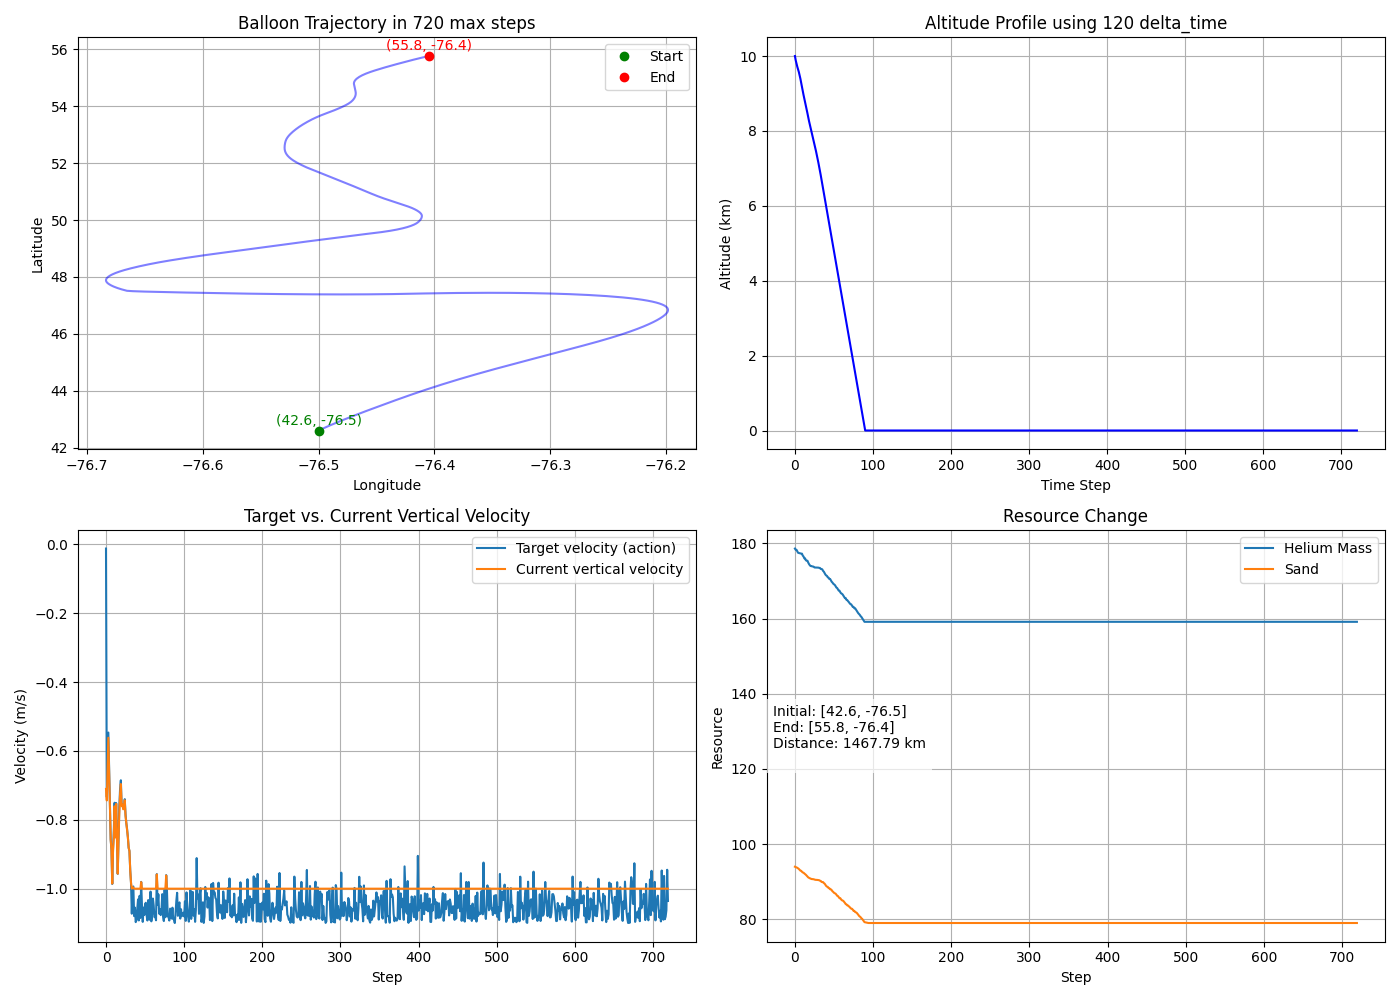

In [36]:
from IPython.display import Image, display
display(Image(filename=expert_plot_fnms_list[0]))

In [37]:
print(expert_total_reward_list)
expert_avg_total_reward = sum(expert_total_reward_list)/len(expert_total_reward_list)
print(f"Expert Trajectory reward in average: {expert_avg_total_reward:.2f}")

[665483.4146355228, 49334.83285420747, 55113.87685294772]
Expert Trajectory reward in average: 256644.04


In [38]:
expert_states_np = np.concatenate(expert_states_list)
expert_actions_np = np.concatenate(expert_actions_list)

## Define our policy network

In [39]:
class PolicyNet(nn.Module):
    def __init__(self, input_dim=21, hidden_dim=64, output_dim=1):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim*2)
        self.ln1 = nn.LayerNorm(hidden_dim*2)
        self.fc2 = nn.Linear(hidden_dim*2, hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

        # Weight initialization
        nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        nn.init.zeros_(self.fc1.bias)
        nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
        nn.init.zeros_(self.fc2.bias)
        nn.init.xavier_uniform_(self.fc3.weight, gain=nn.init.calculate_gain('tanh'))
        nn.init.zeros_(self.fc3.bias)

    def forward(self, x):
        # x shape: (batch_size, input_dim)
        x = self.fc1(x)
        x = self.ln1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.ln2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return F.tanh(x)

# Initialize policy network and optimizer
policy = PolicyNet()
optimizer = optim.Adam(policy.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [ ]:
# Evaluate a policy on the environment
def evaluate_policy(env: BalloonERAEnvironment,
                    policy: nn.Module,
                    objective: str,
                    max_steps: int,
                    policy_name: str,
                    expert_avg_total_reward: float):
    policy.eval()
    if policy.training:
        print("→ policy is in training mode")
    else:
        print("→ policy is in evaluation mode")

    state = env.reset()
    total_reward = 0.0

    # Store trajectory for plotting
    trajectory = [(state[0], state[1])]  # (lat, lon) pairs
    altitudes = [state[2]]  # Store altitudes

    actions = []
    velocities = []
    helium_mass = []
    sands = []

    for step in range(max_steps):
        state_tensor = torch.from_numpy(state).float().unsqueeze(0)      # shape (1, 21)
        action_pred = policy(state_tensor).item()                        # continuous action
        state, reward, done, info = env.step(action_pred)
        total_reward += reward

        actions.append(float(action_pred) if isinstance(action_pred, np.ndarray) else float(action_pred))
        velocities.append(env.balloon.vertical_velocity)
        helium_mass.append(env.balloon.helium_mass)
        sands.append(env.balloon.sand)

        # Store position and altitude
        trajectory.append((state[0], state[1]))
        altitudes.append(state[2])

        if done:
            print(f"\nEpisode terminated: {info}")
            break
    print(f"Total reward obtained from current policy: {total_reward:.2f}")
    print(f"Expert policy reward - Current policy reward: {expert_avg_total_reward-total_reward:.2f}")

    # Plot summary (figs/BC_fly)
    plot_fnm = plot_agent_summary(
        trajectory=trajectory,
        altitudes=altitudes,
        actions=actions,
        velocities=velocities,
        helium_mass=helium_mass,
        sands=sands,
        policy_name=policy_name,
        max_steps=max_steps,
        dt=env.dt,
        objective=objective,
        target_lon=env.target_lon,
        target_lat=env.target_lat,
        target_alt=env.target_alt
        )

    return total_reward, plot_fnm

In [ ]:
env.wind_field.disable_noise()
# env.wind_field.enable_noise(noise_seed=10) # If you want to enable noisy wind field
total_reward, random_fnm = evaluate_policy(env, policy, objective, max_steps=max_steps, policy_name='random_policy', expert_avg_total_reward=expert_avg_total_reward)

→ policy is in evaluation mode

Episode terminated: No sand left
Total reward obtained from current policy: 385922.15
Expert policy reward - Current policy reward: -385922.15
Initial position: [42.6, -76.5], End position: [57.3, -74.6], Distance: 1640.04555160024 km


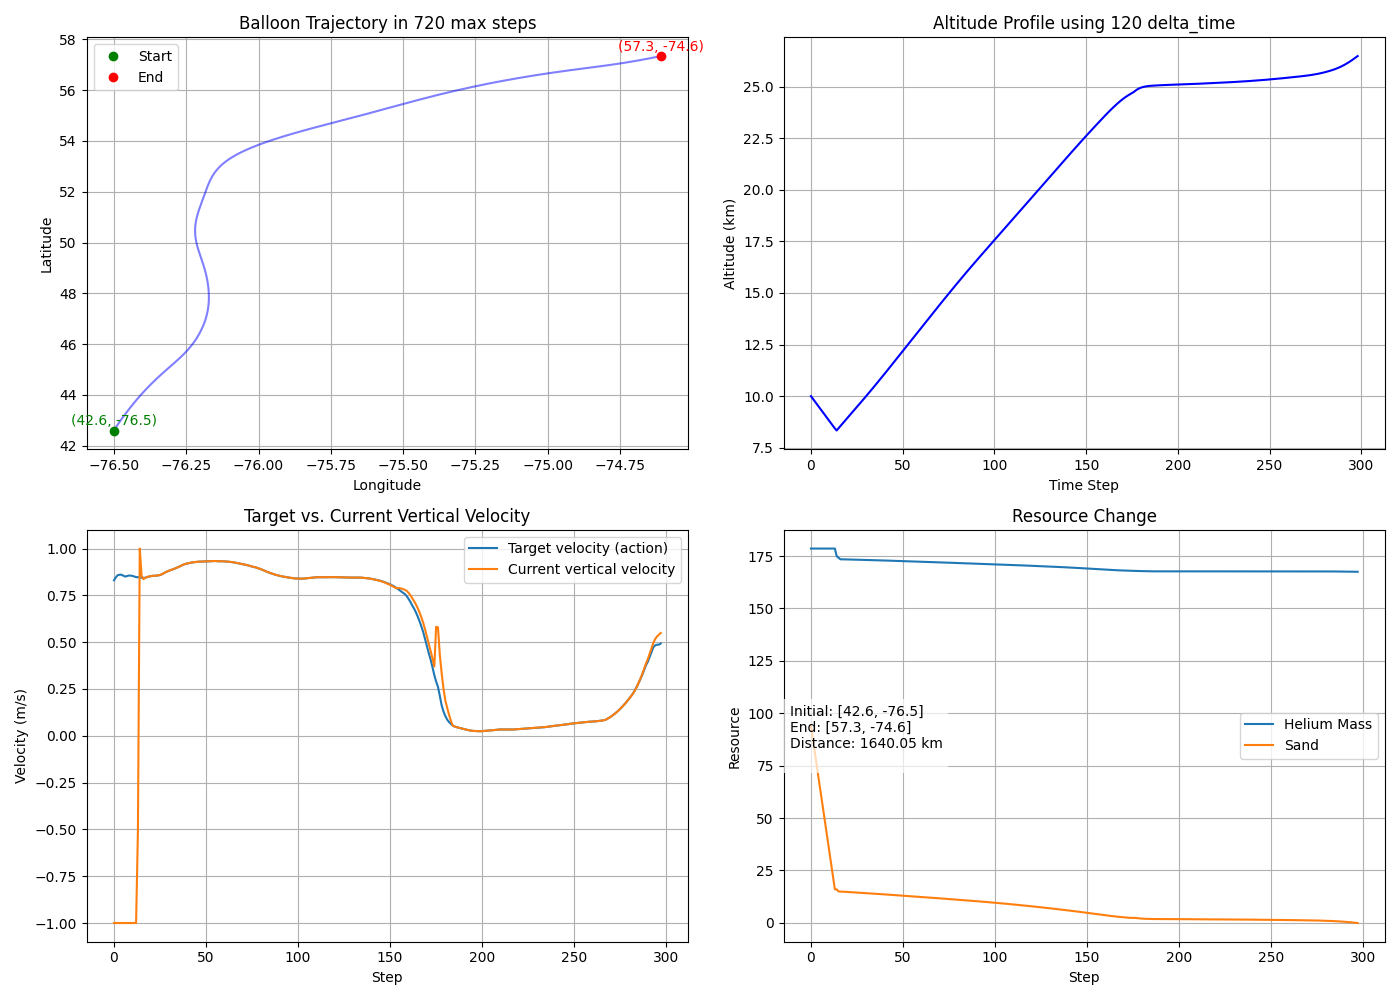

In [42]:
display(Image(filename=random_fnm))

## Behavior Cloning (Supervised Learning)

In [43]:
# === Initial Dataset & DataLoader Construction ===

# Convert to tensors
states_tensor = torch.from_numpy(expert_states_np).float()               # shape (N, 21)
actions_tensor = torch.from_numpy(expert_actions_np).float()             # shape (N, 1)

# Construct TensorDataset and DataLoader
dataset = TensorDataset(states_tensor, actions_tensor)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [44]:
# === Training Function Using Loader ===
def train_one_epoch(loader, policy, optimizer, loss_fn):
    policy.train()
    if policy.training:
        print("→ policy is in training mode")
    else:
        print("→ policy is in evaluation mode")

    total_loss = 0.0
    for x_batch, y_batch in loader:
        optimizer.zero_grad()
        preds = policy(x_batch)
        loss = loss_fn(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x_batch.size(0)
    avg_loss = total_loss / len(loader.dataset)
    return avg_loss

→ policy is in training mode
Epoch 1/10 — Avg Loss: 0.684852 

→ policy is in training mode
Epoch 2/10 — Avg Loss: 0.009765 

→ policy is in training mode
Epoch 3/10 — Avg Loss: 0.009748 

→ policy is in training mode
Epoch 4/10 — Avg Loss: 0.009747 

→ policy is in training mode
Epoch 5/10 — Avg Loss: 0.009746 

→ policy is in training mode
Epoch 6/10 — Avg Loss: 0.009746 

→ policy is in training mode
Epoch 7/10 — Avg Loss: 0.009746 

→ policy is in training mode
Epoch 8/10 — Avg Loss: 0.009746 

→ policy is in training mode
Epoch 9/10 — Avg Loss: 0.009746 

→ policy is in training mode
Epoch 10/10 — Avg Loss: 0.009746 



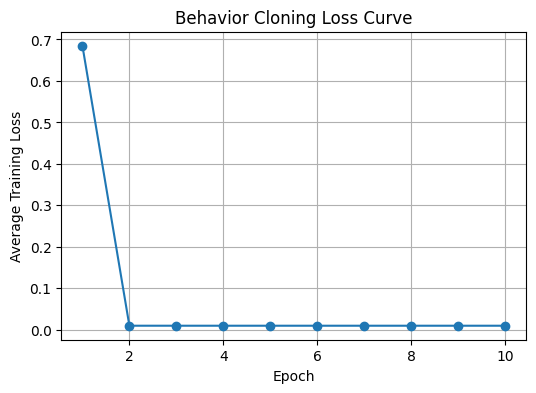

In [45]:
losses = []
for epoch in range(10):
    avg_loss = train_one_epoch(loader, policy, optimizer, loss_fn)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/10 — Avg Loss: {avg_loss:.6f} \n")

# plot the loss curve from behavior cloning
plt.figure(figsize=(6,4))
plt.plot(range(1, len(losses)+1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Training Loss')
plt.title('Behavior Cloning Loss Curve')
plt.grid(True)
plt.show()

In [46]:
env.wind_field.disable_noise()
# env.wind_field.enable_noise(noise_seed=10) # If you want to enable noisy wind field
toal_reward, BC_trained_fnm = evaluate_policy(env, policy, max_steps=max_steps, policy_name='BC_trained_far_policy', expert_avg_total_reward=expert_avg_total_reward)

→ policy is in evaluation mode

Episode terminated: Time limit reached
Total reward obtained from current policy: 1308745.97
Expert policy reward - Current policy reward: -1052101.93
Initial position: [42.6, -76.5], End position: [56.9, -73.2], Distance: 1607.1904928593176 km


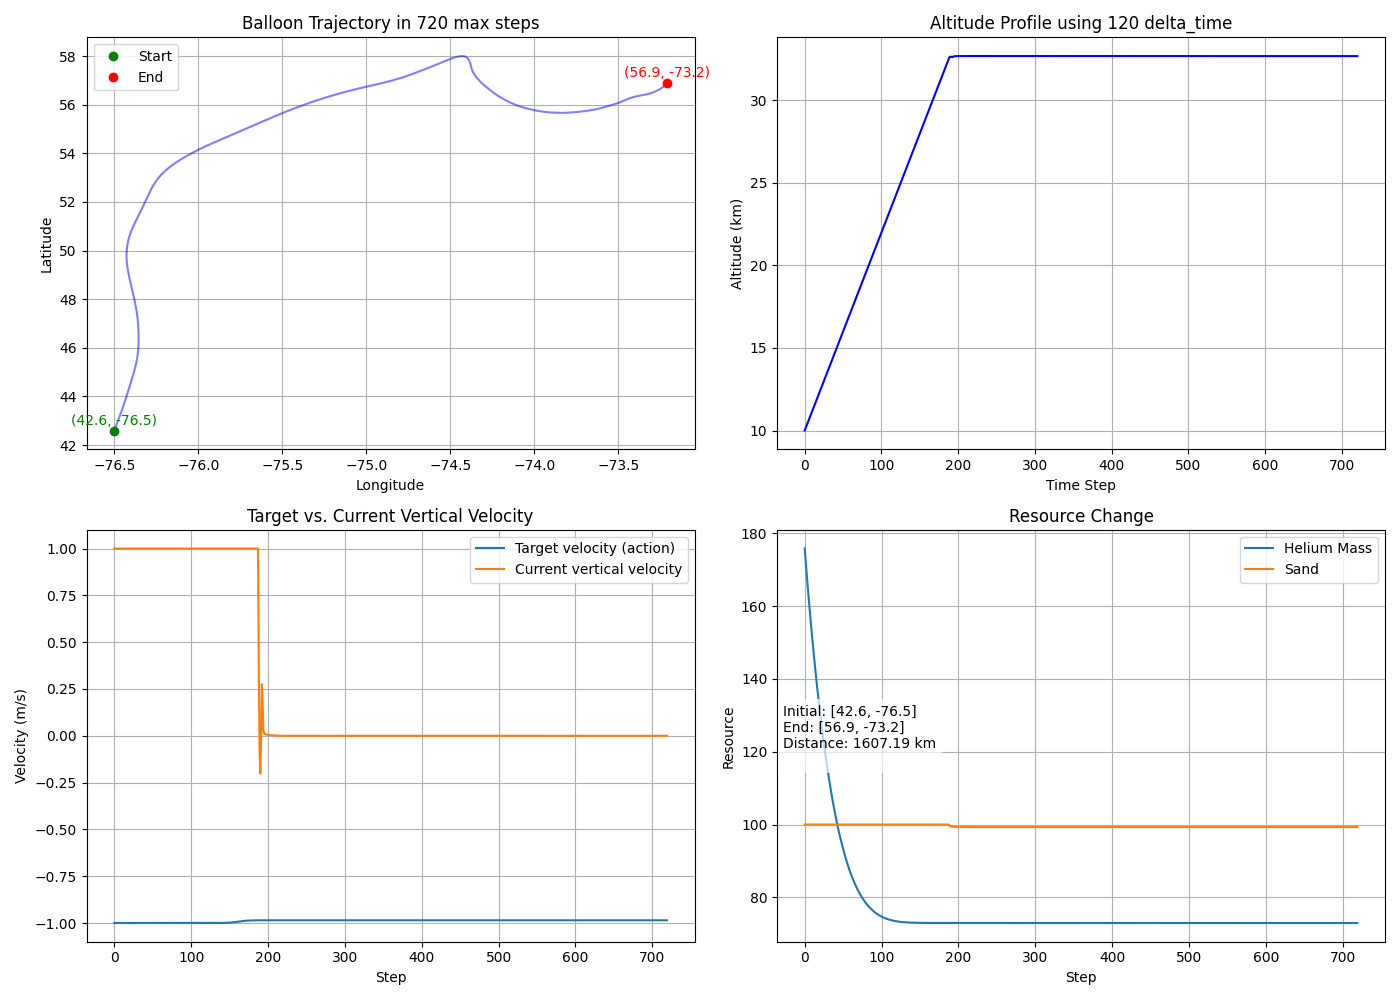

In [47]:
display(Image(filename=BC_trained_fnm))